## Aligning the coordinates between Xenium and IF scan

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio as io
import cv2
import pathlib
from pyometiff import OMETIFFReader
import imageio as io
from __future__ import print_function
import scanpy as sc
import os
import pandas as pd
import PIL
from tqdm.notebook import tqdm

Go to Qupath > file > open > click on the vsi file of the IF > Fluorescence image > File > Export Images > original pixels > type: ome tiff > specify file name and directory > Let it save out > Enter path to OME TIFF below

In [2]:
path_to_IF_ome = 'D:/amonell/RaRi/IF_scans/Image_Xenium_RARI_IF.ome.ome.tif'

In [ ]:

img_fpath = pathlib.Path(path_to_IF_ome)

reader = OMETIFFReader(fpath=img_fpath)

img_array_if, metadata_if, xml_metadata = reader.read()

Display downsized image in the DAPI channel to make sure you're looking at the right experiment (if the dapi image is the first one in the stack then it would be channel 0)

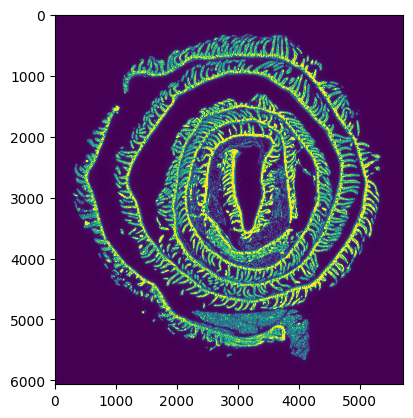

In [4]:
channel_display = 0
down_factor = 10

new_width = int(img_array_if[channel_display].shape[1] / down_factor)
new_height = int(img_array_if[channel_display].shape[0] / down_factor)

# Resize the image
thumbnail = cv2.resize(img_array_if[channel_display], (new_width, new_height))
plt.imshow(thumbnail, vmax=np.percentile(thumbnail, 95))

## PLEASE MAKE SURE YOU SELECTED THE DAPI CHANNEL FROM IF 

We first downsize the image dimensions by 2x, because cv2 has a limit on image size when warping with a matrix transformation. If a stange error is thrown during matrix warping, the images may be to big and will need to be downsized further (This will require changing the padding part in the code below to make our images divisible by 3x, 4x or further instead of 2x). We also need to pad the image beforehand to be divisible by 2, to keep pixel level precision.

In [50]:

downscale_factor = 2

pad_height = (downscale_factor - img_array_if[channel_display].shape[0] % downscale_factor) % downscale_factor
pad_width = (downscale_factor - img_array_if[channel_display].shape[1] % downscale_factor) % downscale_factor

# Pad the array with zeros
padded_IF = np.pad(img_array_if[channel_display], ((0, pad_height), (0, pad_width)), mode='constant')

new_width = int(padded_IF.shape[1] / downscale_factor)
new_height = int(padded_IF.shape[0] / downscale_factor)

# Resize the image
resized_image = cv2.resize(padded_IF, (new_width, new_height))
if_image = resized_image

## Read in Xenium morphology

Put the path to the corresponding Xenium experiment below

In [2]:
xenium_path = 'D:/amonell/RaRi/output-XETG00095__0005184__DMSO__20230715__015401'

In [4]:

img_fpath = pathlib.Path(os.path.join(xenium_path, 'morphology_focus.ome.tif'))

reader = OMETIFFReader(fpath=img_fpath)

img_array_xenium, metadata_xenium, xml_metadata = reader.read()

Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'


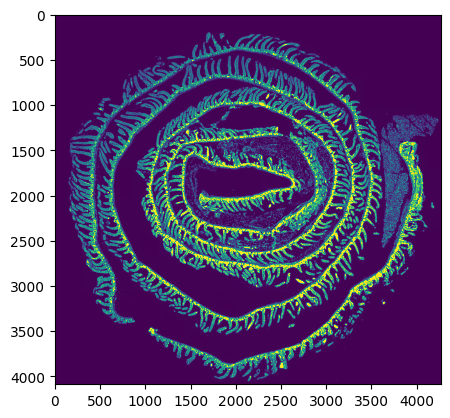

In [8]:
down_factor = 10

new_width = int(img_array_xenium.shape[1] / down_factor)
new_height = int(img_array_xenium.shape[0] / down_factor)

# Resize the image
thumbnail = cv2.resize(img_array_xenium, (new_width, new_height))
plt.imshow(thumbnail, vmax=np.percentile(thumbnail, 95))

Do the same exact padding and downsizing as with the IF

In [51]:
downscale_factor = 2
# Calculate the amount of padding needed for each axis
pad_height = (downscale_factor - img_array_xenium.shape[0] % downscale_factor) % downscale_factor
pad_width = (downscale_factor - img_array_xenium.shape[1] % downscale_factor) % downscale_factor

# Pad the array with zeros
padded_array = np.pad(img_array_xenium, ((0, pad_height), (0, pad_width)), mode='constant')

# Now 'padded_array' will have both axes sizes divisible by 2
img_array_xenium = padded_array

new_width = int(img_array_xenium.shape[1] /downscale_factor) 
new_height = int(img_array_xenium.shape[0] / downscale_factor)

# Resize the image
resized_xenium = cv2.resize(img_array_xenium, (new_width, new_height))


# Matching keypoints and warping
This is the most important part. You may have to tune some of these parameters to get enough keypoint matches for the transformation to occur. However these parameters work for the initial small intestine rolls.

Also can implement a drawing of the keypoint matches, since cv2 function does not allow you to change line weight, but not necessary for functionality so skipping for now

In [54]:
#max number of corners to detect in each image
MAX_FEATURES = 4000
#percent of corner patches to keep
GOOD_MATCH_PERCENT = 0.5
#how much to blur the initial images to capture villi structure keypoints
blur_res = (10, 10)


def alignImages(im1, im2):

    print('keypoint detection...')
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES, patchSize= 100)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
    print(len(keypoints1))
    print(len(keypoints2))
    print('feature matching...')
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    matches = list(matches)
    print(len(matches))
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    print('prune bad matches...')
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    # Draw top matches
    # imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    # plt.figure(dpi=200)
    # plt.imshow(imMatches)
    # plt.show()
    #cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h
 

print("Aligning images ...")
# Registered image will be resotred in imReg.
# The estimated homography will be stored in h.
imReg, h = alignImages(cv2.blur(((resized_image/np.max(resized_image))*255).astype(np.uint8), blur_res), cv2.blur(((resized_xenium/np.max(resized_xenium))*255).astype(np.uint8), blur_res))

# Print estimated homography
print("Estimated homography : \n",  h)

Aligning images ...
keypoint detection...
2796
4000
feature matching...
2796
prune bad matches...
Estimated homography : 
 [[ 7.41966896e-03  7.67003843e-01 -6.28520160e+02]
 [-7.66094444e-01  6.31628279e-03  2.13516951e+04]
 [ 1.32375609e-07  1.93634726e-08  1.00000000e+00]]


# Using homography matrix to calculate IF image warped

In [57]:
height, width = resized_xenium.shape
im1Reg = cv2.warpPerspective(resized_image, h, (width, height))

new_width = int(im1Reg.shape[1] *2) 
new_height = int(im1Reg.shape[0] *2)

# Resize the image
warped = cv2.resize(im1Reg, (new_width, new_height))

Below should show the warped IF in the first axis, and xenium in the second. If this looks right, continue. If the warped image looks like a giant smear, change the parameters in the keypoint function. This should be accurate to the pixel level, as keypoints are found at the subpixel level. No need for subsequent dapi registration

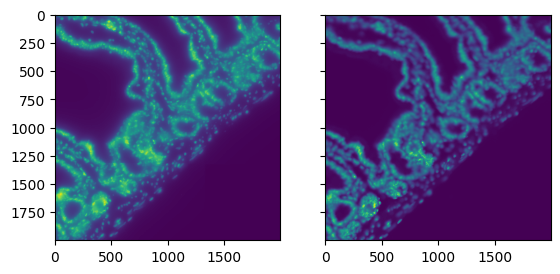

In [58]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(warped[10000:12000, 10000:12000])
ax2.imshow(img_array_xenium[10000:12000, 10000:12000])
plt.show()
#downsize for diplay before this
# fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
# ax1.imshow(warped)
# ax2.imshow(img_array_xenium)
# plt.show()

## Recreating the IF tiff ome to be the right size

This part of the code is just warping each frame of the IF tiff based on the matrix calculated before, and then saving them out to the xenium data folder

In [64]:
for i in tqdm(range(np.shape(img_array_if)[0])):
    current_img = img_array_if[i]
    
    pad_height = (2 - current_img.shape[0] % 2) % 2
    pad_width = (2 - current_img.shape[1] % 2) % 2
    
    # Pad the array with zeros
    padded_IF = np.pad(current_img, ((0, pad_height), (0, pad_width)), mode='constant')
    
    new_width_ = int(padded_IF.shape[1] / downscale_factor)
    new_height_ = int(padded_IF.shape[0] / downscale_factor)
    
    # Resize the image
    resized_image_ = cv2.resize(padded_IF, (new_width_, new_height_))
    
    height_, width_ = resized_xenium.shape
    im1Reg_ = cv2.warpPerspective(resized_image_, h, (width_, height_))    
    
    new_width_ = int(im1Reg_.shape[1] *2) 
    new_height_ = int(im1Reg_.shape[0] *2)
    
    warped_ = cv2.resize(im1Reg_, (new_width_, new_height_))   
    io.imsave(os.path.join(xenium_path, f'IF_warped_channel{i}.png'), warped_)

  0%|          | 0/2 [00:00<?, ?it/s]

# Visualization of integration (Not automated, change parts of this to see the channels and regions that you want)

Grabbing the all IF channels for visualization

In [5]:
PIL.Image.MAX_IMAGE_PIXELS = 4902390226
channel_values = io.imread(os.path.join(xenium_path, f'IF_warped_channel{0}.png'))

C:\Users\amonell\AppData\Local\Temp\3\ipykernel_46532\858611591.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  channel_values = io.imread(os.path.join(xenium_path, f'IF_warped_channel{0}.png'))
C:\Users\amonell\anaconda3_2\envs\cellpose_only\lib\site-packages\imageio\plugins\pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


In [6]:
channel_values2 = io.imread(os.path.join(xenium_path, f'IF_warped_channel{1}.png'))

C:\Users\amonell\AppData\Local\Temp\3\ipykernel_46532\2225561263.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  channel_values2 = io.imread(os.path.join(xenium_path, f'IF_warped_channel{1}.png'))


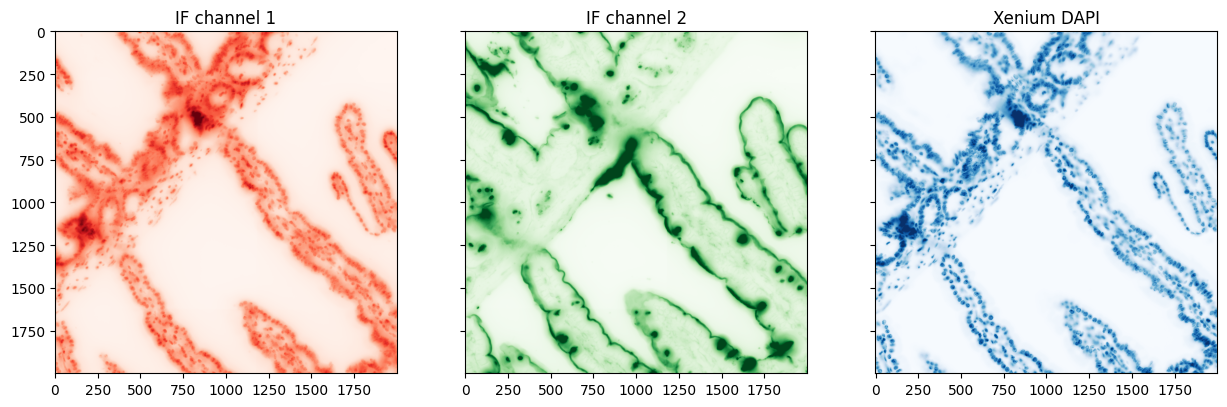

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize= (15, 5))
ax1.imshow(channel_values[10000:12000, 10000:12000], cmap='Reds')
ax1.set_title('IF channel 1')
ax2.imshow(channel_values2[10000:12000, 10000:12000], cmap='Greens')
ax2.set_title('IF channel 2')
ax3.imshow(img_array_xenium[10000:12000, 10000:12000], cmap='Blues')
ax3.set_title('Xenium DAPI')
plt.show()